# Validation Analysis

## Objective
Develop accuracy assessments for tree cover predictions in each country, region, subregion, ecoregion and biome to understand how the model performs differently in each class and determine where we need more data.  
Ultimately we want report that the error of the model at predicting tree cover was x +/- y at the 95% confidence level. 

How confident are we that a certain range around these estimates of tree cover actually contains the true parameter? In other words, what do the error bars look like for precision, recall and f1? How granular can we make these validation assessments for each region/subregion/ecoregion? 

**Steps**
- Bootstrap sample n times from each biome
- Calculate precision, recall and F1 scores for each bootstrap
- Calculate 75%, 95%, 99% confidence intervals for the samples
- Repeat for other categories and see what the error bars look like
- Visualize error bars


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## Quick EDA

In [4]:
df = pd.read_csv('../evaluation_joined.csv')
df2 = df.copy(deep = True)
df2['rvalue_1'] = 'Overall'
df = pd.concat([df, df2])
df.head(5)

,plot_id,lat,long,y,error,tp,fp,fn,tree_cover,scalerank,...,un_a3,wb_a2,wb_a3,woe_id,adm0_a3_is,continent,region_un,subregion,region_wb,rvalue_1
0,139190211,21.027668,-76.510096,124,7,117,0,7,63,1.0,...,192.0,CU,CUB,-99.0,CUB,North America,Americas,Caribbean,Latin America & Caribbean,Cropland
1,139252908,20.967266,-77.529671,22,1,16,6,6,11,1.0,...,192.0,CU,CUB,-99.0,CUB,North America,Americas,Caribbean,Latin America & Caribbean,Cropland
2,139264386,20.264845,-75.939216,12,0,6,2,6,6,1.0,...,192.0,CU,CUB,-99.0,CUB,North America,Americas,Caribbean,Latin America & Caribbean,Cropland
3,139270431,19.190618,-70.201751,55,-12,50,10,5,28,1.0,...,214.0,DO,DOM,-99.0,DOM,North America,Americas,Caribbean,Latin America & Caribbean,Cropland
4,139190209,21.027668,-76.063330,136,5,131,0,5,69,1.0,...,192.0,CU,CUB,-99.0,CUB,North America,Americas,Caribbean,Latin America & Caribbean,Cropland


In [5]:
df['rvalue_1'].unique()

array(['Cropland', 'Grassland', 'Forest', 'Mosaic vegetation',
       'Shrub/scrub/otherland', 'Urban', 'Overall'], dtype=object)

In [6]:
df.columns

Index(['plot_id', 'lat', 'long', 'y', 'error', 'tp', 'fp', 'fn', 'tree_cover',
       'scalerank', 'sovereignt', 'name_alt', 'pop_est', 'gdp_md_est',
       'lastcensus', 'gdp_year', 'economy', 'income_grp', 'un_a3', 'wb_a2',
       'wb_a3', 'woe_id', 'adm0_a3_is', 'continent', 'region_un', 'subregion',
       'region_wb', 'rvalue_1'],
      dtype='object')

In [7]:
#df['tp'] = df['tp'].astype(int)
df['fp'] = df['fp'].astype(int)
#df['fn'] = df['fn'].astype(int)

## Bootstrap from each scale, calculate scores and confidence intervals

In [32]:
def bootstrap(df, scale, n):
    
    '''
    Function takes in a df, bootstraps n samples from each category in a column (scale) 
    and calculates the precision, recall and f1. Then takes percentiles of the bootstrap 
    to calculate confidence intervals. Returns separate dfs with the scores and CIs.
    '''
    
    # get a list of categories within the scale, dropping categories with less than 5 rows
    #df = df.groupby(scale).filter(lambda x: len(x)>5)   
    categories = set(df[scale].dropna().unique())
    print(f'{scale} has {len(categories)} subcategories. {len(categories)*n} samples in total.')
    
                     
    # empty df to store samples, scores and CIs
    val_df = pd.DataFrame(columns = ['scale', 'category', 'precision', 'recall', 'f1'])
    conf_int = pd.DataFrame(columns = ['scale', 'category',
                                       'p_lower_95', 'p_upper_95', 'r_lower_95',
                                       'r_upper_95', 'f1_lower_95','f1_upper_95',
                                       'p_lower_90', 'p_upper_90', 'r_lower_90',
                                       'r_upper_90', 'f1_lower_90','f1_upper_90',
                                       'p_lower_80', 'p_upper_80', 'r_lower_80',
                                       'r_upper_80', 'f1_lower_80','f1_upper_80', 'lower_conf_range',
                                      'upper_conf_range'])

    # calculation for precision, recall, f1
    def calculate_metrics(tp, fp, fn):
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))
        return precision, recall, f1
    
    # for each category in scale, calculate scores, 
    for i in categories:
        grouped = df[df[scale] == i]
        bootsamples = pd.DataFrame()
        
        for num in range(n):  
            bootstrap = grouped.sample(len(grouped), replace=True)
            #bootsamples = bootsamples.append(bootstrap, ignore_index = True)
            precision, recall, f1 = calculate_metrics(sum(bootstrap.tp.values), 
                                                      sum(bootstrap.fp.values), 
                                                      sum(bootstrap.fn.values))
            
            # add calculations to empty df
            val_df = val_df.append({'scale': scale, 
                                   'category': i,
                                   'precision': precision,
                                   'recall': recall,
                                   'f1': f1}, ignore_index = True)
    
    # use scores in val_df to calculate CIs
    for i in categories:
        grouped2 = val_df[val_df.category == i] 

        # calculate 80, 90, 95th percentile
        p_lower_95, r_lower_95, f1_lower_95 = np.percentile(grouped2.precision.values, 2.5),\
                                              np.percentile(grouped2.recall.values, 2.5),\
                                              np.percentile(grouped2.f1.values, 2.5) 
        p_upper_95, r_upper_95, f1_upper_95 = np.percentile(grouped2.precision.values, 97.5),\
                                              np.percentile(grouped2.recall.values, 97.5),\
                                              np.percentile(grouped2.f1.values, 97.5)
                

        p_lower_90, r_lower_90, f1_lower_90 = np.percentile(grouped2.precision.values, 5),\
                                              np.percentile(grouped2.recall.values, 5),\
                                              np.percentile(grouped2.f1.values, 5) 
        p_upper_90, r_upper_90, f1_upper_90 = np.percentile(grouped2.precision.values, 95),\
                                              np.percentile(grouped2.recall.values, 95),\
                                              np.percentile(grouped2.f1.values, 95)
        

        p_lower_80, r_lower_80, f1_lower_80 = np.percentile(grouped2.precision.values, 10),\
                                              np.percentile(grouped2.recall.values, 10),\
                                              np.percentile(grouped2.f1.values, 10) 
        p_upper_80, r_upper_80, f1_upper_80 = np.percentile(grouped2.precision.values, 90),\
                                              np.percentile(grouped2.recall.values, 90),\
                                              np.percentile(grouped2.f1.values, 90)
        print(len(grouped2.recall.values))
        lower_conf_range = np.percentile(grouped2.recall.values - grouped2.precision.values,
                                                           2.5)
        upper_conf_range = np.percentile(grouped2.recall.values - grouped2.precision.values,
                                                           97.5)
        
        
        # add percentiles to empty df
        conf_int = conf_int.append({'scale': scale, 
                                    'category': i,
                                   'p_lower_95': p_lower_95, 
                                   'p_upper_95': p_upper_95, 
                                   'r_lower_95': r_lower_95,
                                   'r_upper_95': r_upper_95, 
                                   'f1_lower_95': f1_lower_95,
                                   'f1_upper_95': f1_upper_95,
                                   'p_lower_90': p_lower_90, 
                                   'p_upper_90': p_upper_90, 
                                   'r_lower_90': r_lower_90,
                                   'r_upper_90': r_upper_90, 
                                   'f1_lower_90': f1_lower_90,
                                   'f1_upper_90': f1_upper_90,
                                   'p_lower_80': p_lower_80, 
                                   'p_upper_80': p_upper_80, 
                                   'r_lower_80': r_lower_80,
                                   'r_upper_80': r_upper_80, 
                                   'f1_lower_80': f1_lower_80,
                                   'f1_upper_80': f1_upper_80,
                                   'lower_conf_range': lower_conf_range,
                                   'upper_conf_range': upper_conf_range}, ignore_index = True)
        
    # add columns with the mean precision, recall and f1 to CI dataframe (pd can only merge 2 df at a time)
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).precision.mean().reset_index(), on='category')
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).recall.mean().reset_index(), on='category')
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).f1.mean().reset_index(), on='category')
    
    # add column with # of samples to CI dataframe
    sample_size = df[scale].value_counts().to_frame().reset_index()
    sample_size.columns = ['category', 'num_samples']
    conf_int = pd.merge(conf_int, sample_size, on='category')

    # returns scores and conf intervals separately
    return val_df, conf_int

In [33]:
subregion_val, subregion_conf = bootstrap(df, 'subregion', 200)

subregion has 13 subcategories. 2600 samples in total.
200
200
200
200
200
200
200
200
200
200
200
200
200


In [34]:
subregion_conf.head(10)

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,...,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80,lower_conf_range,upper_conf_range,precision,recall,f1,num_samples
0,subregion,South America,0.965788,0.982006,0.980533,0.986889,0.974400,0.984155,0.968061,0.980471,...,0.982115,0.986069,0.976871,0.982344,0.002026,0.019948,0.974870,0.984108,0.979464,598
1,subregion,Western Africa,0.930161,0.960711,0.933993,0.962323,0.935963,0.957695,0.933109,0.958457,...,0.941026,0.957585,0.940826,0.954440,-0.017769,0.024943,0.946559,0.949723,0.948114,294
2,subregion,Melanesia,0.996297,0.999769,0.993211,0.998283,0.995256,0.998608,0.996637,0.999630,...,0.994159,0.997668,0.996023,0.998168,-0.005828,0.001423,0.998276,0.995918,0.997095,114
3,subregion,Eastern Africa,0.864388,0.924830,0.907450,0.943034,0.889742,0.929971,0.872999,0.921824,...,0.916707,0.938783,0.901763,0.925736,0.001962,0.061454,0.899310,0.928236,0.913485,456
4,subregion,Southern Asia,0.959508,0.983756,0.933645,0.975151,0.948492,0.975888,0.961950,0.982728,...,0.946303,0.970090,0.956639,0.974039,-0.036619,0.005291,0.972373,0.958658,0.965449,82
5,subregion,Central America,0.961426,0.979144,0.974041,0.984062,0.969948,0.981195,0.963422,0.978399,...,0.976543,0.983054,0.972003,0.979396,-0.002702,0.019982,0.971427,0.979673,0.975527,294
6,subregion,Southern Africa,0.871120,0.980942,0.838013,0.950813,0.863820,0.963038,0.895639,0.979190,...,0.872922,0.942050,0.896669,0.955926,-0.090649,0.021198,0.947965,0.912657,0.929857,50
7,subregion,Western Asia,0.879475,0.956869,0.887096,0.949500,0.890023,0.950497,0.886108,0.953915,...,0.907474,0.943253,0.905996,0.943715,-0.051291,0.048566,0.929911,0.925416,0.927526,64
8,subregion,Middle Africa,0.974000,0.988806,0.969094,0.983714,0.972905,0.984967,0.975151,0.988121,...,0.972053,0.981534,0.975901,0.983312,-0.016051,0.006451,0.982544,0.977233,0.979875,326
9,subregion,South-Eastern Asia,0.988214,0.993835,0.989060,0.995430,0.989495,0.994109,0.988747,0.993528,...,0.990491,0.994550,0.990565,0.993377,-0.004535,0.007000,0.991310,0.992580,0.991943,352


In [14]:
biome_val, biome_conf = bootstrap(df, 'Biome', 50)

KeyError: 'Biome'

In [17]:
region_val, region_conf = bootstrap(df, 'region_un', 1000)

region_un has 4 subcategories. 4000 samples in total.


In [50]:
country_val, country_conf = bootstrap(df, 'country', 1000)

country has 48 subcategories. 48000 samples in total.


/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [98]:
lulc_val, lulc_conf = bootstrap(df, 'rvalue_1', 5000)
#lulc_conf.to_csv("lulc-confidence-intervals.csv", index = False)

rvalue_1 has 7 subcategories. 35000 samples in total.


In [51]:
treeclass_val, treeclass_conf = bootstrap(df, 'tree_class', 1000)

tree_class has 5 subcategories. 5000 samples in total.


In [16]:
subcover, subcover_conf = bootstrap(df, 'subregion_cover', 1000)

KeyError: 'subregion_cover'

In [217]:
subcover_conf = subcover_conf.sort_values("category", ascending = False)

## Visuals: Pointplot + Errorplot

In [84]:
from matplotlib.transforms import ScaledTranslation

def errorplot_precision_recall(conf_df, figsize, title):
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
    
    plt.rc('font', **font)

    
    fig, ax = plt.subplots(figsize=figsize)
    #ax.figure(figsize=figsize)

    x_p = conf_df.precision
    x_r = conf_df.recall
    y = conf_df.category
    print(y)

    # define precalculated error bars
    p_lower_95 = conf_df['precision'] - conf_df['p_lower_95'] 
    p_upper_95 = conf_df['p_upper_95'] - conf_df['precision'] 
    p_lower_90 = conf_df['precision'] - conf_df['p_lower_90'] 
    p_upper_90 = conf_df['p_upper_90'] - conf_df['precision'] 
    p_lower_80 = conf_df['precision'] - conf_df['p_lower_80'] 
    p_upper_80 = conf_df['p_upper_80'] - conf_df['precision'] 
    
    # define precalculated error bars
    r_lower_95 = conf_df['recall'] - conf_df['r_lower_95'] 
    r_upper_95 = conf_df['r_upper_95'] - conf_df['recall'] 
    r_lower_90 = conf_df['recall'] - conf_df['r_lower_90'] 
    r_upper_90 = conf_df['r_upper_90'] - conf_df['recall'] 
    r_lower_80 = conf_df['recall'] - conf_df['r_lower_80'] 
    r_upper_80 = conf_df['r_upper_80'] - conf_df['recall']
    
    trans1 = ax.transData + ScaledTranslation(0, -7/72, fig.dpi_scale_trans)
    trans2 = ax.transData + ScaledTranslation(0, +7/72, fig.dpi_scale_trans)

    # plot error bars (3x for precision, 3x for recall)
    ax.errorbar(x_p, y, xerr=[p_lower_95, p_upper_95], fmt='.', ecolor='lightcoral', transform=trans1,
                 elinewidth=3, markerfacecolor='grey', markeredgecolor='grey', capsize=3, )
    ax.errorbar(x_p, y, xerr=[p_lower_90, p_upper_90], fmt='.', ecolor='orangered', transform=trans1,
                 elinewidth=6, markerfacecolor='grey', markeredgecolor='grey', capsize=3)
    ax.errorbar(x_p, y, xerr=[p_lower_80, p_upper_80], fmt='.', ecolor='crimson', transform=trans1,
                 elinewidth=12, markerfacecolor='grey', markeredgecolor='grey', capsize=3)
    
    ax.errorbar(x_r, y, xerr=[r_lower_95, r_upper_95], fmt='.', ecolor='lightsteelblue',  transform=trans2,
                 elinewidth=3, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    ax.errorbar(x_r, y, xerr=[r_lower_90, r_upper_90], fmt='.', ecolor='royalblue',  transform=trans2,
                 elinewidth=6, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    ax.errorbar(x_r, y, xerr=[r_lower_80, r_upper_80], fmt='.', ecolor='mediumblue',  transform=trans2,
                 elinewidth=12, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    ax.set(xlabel='Accuracy metric', ylabel=None)
    
    # create y axis labels
    labels = (': '.join(item) for item in zip(conf_df.category, conf_df.num_samples.apply(str)))
    plt.yticks(range(len(conf_df)), labels)
    
    # format title and legend
    plt.title(f"Accuracy metrics for {title}")
    plt.grid(axis='y', linestyle='-', linewidth=.5)
    ci80_b = mpatches.Patch(color='mediumblue', label="80% Conf. PA")
    ci80_r = mpatches.Patch(color='crimson', label="80% Conf. UA")
    ci90_b = mpatches.Patch(color='royalblue', label="90% Conf. PA")
    ci90_r = mpatches.Patch(color='orangered', label="90% Conf. UA")
    ci95_b = mpatches.Patch(color='lightsteelblue', label="95% Conf. PA")
    ci95_r = mpatches.Patch(color='lightcoral', label="95% Conf. UA")
    mean_p = mpatches.Patch(color='grey', edgecolor = 'black', label="Mean UA")
    mean_r = mpatches.Patch(color='gold', label="Mean PA")
    plt.legend(handles=[ci80_b, ci90_b, ci95_b, mean_r, ci80_r, ci90_r, ci95_r, mean_p], 
               title='Key', 
               bbox_to_anchor=(1.05, 1), 
               loc='upper left');
    plt.xlim(0.7,1.0)
    
    return None

### Region

### Subregion

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


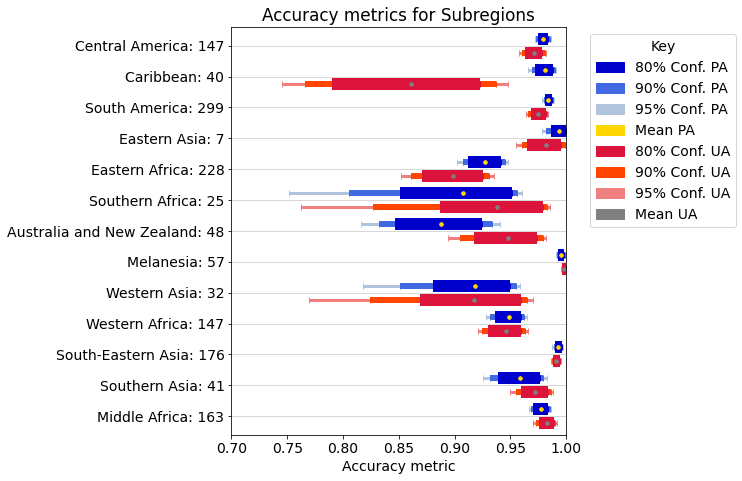

In [46]:
errorplot_precision_recall(subregion_conf, (6, 7.5), 'Subregions')
plt.savefig("subregion.pdf", dpi = 200, bbox_inches = "tight")
plt.savefig("subregion.png", dpi = 200, bbox_inches = "tight")

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


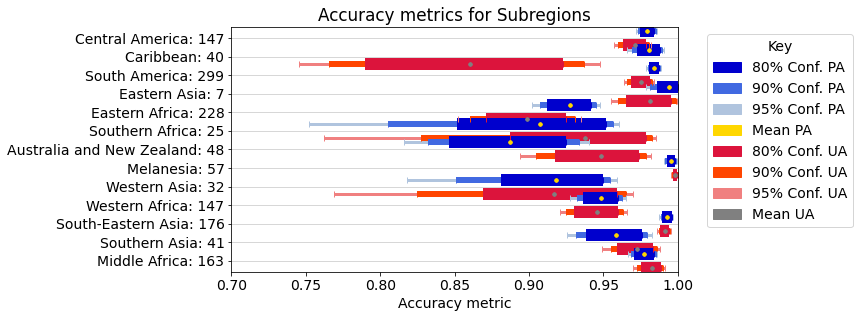

In [45]:
errorplot_precision_recall(subregion_conf, (8, 4.5), 'Subregions')
plt.savefig("subregion.pdf", dpi = 200, bbox_inches = "tight")
plt.savefig("subregion.png", dpi = 200, bbox_inches = "tight")




In [100]:
lulc_conf.head(10)
lulc_conf = lulc_conf.reindex([3, 0, 1, 2, 4, 5, 6])
lulc_conf = lulc_conf.reset_index(drop = True)

In [101]:
lulc_conf.head(10)

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,...,p_lower_80,p_upper_80,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80,precision,recall,f1,num_samples
0,rvalue_1,Overall,0.964128,0.975022,0.972707,0.979504,0.969481,0.976372,0.965077,0.974321,...,0.966125,0.973426,0.974068,0.978459,0.970771,0.975288,0.969849,0.976275,0.973049,1417
1,rvalue_1,Mosaic vegetation,0.897365,0.965209,0.916692,0.966909,0.912591,0.961853,0.906084,0.961525,...,0.913640,0.956785,0.928318,0.960445,0.924308,0.955220,0.936247,0.944956,0.940501,159
2,rvalue_1,Urban,0.706516,0.932379,0.751014,0.945571,0.748520,0.920916,0.736320,0.924229,...,0.766748,0.910947,0.806813,0.927476,0.800000,0.905100,0.845201,0.872362,0.857213,14
3,rvalue_1,Cropland,0.915986,0.952605,0.945457,0.964075,0.933208,0.955859,0.919480,0.950384,...,0.923934,0.947854,0.949200,0.961449,0.938137,0.952799,0.936274,0.955419,0.945725,422
4,rvalue_1,Forest,0.991820,0.996853,0.993298,0.996871,0.993112,0.996439,0.992312,0.996497,...,0.992878,0.996164,0.993997,0.996351,0.993791,0.995910,0.994561,0.995208,0.994884,446
5,rvalue_1,Grassland,0.866713,0.936584,0.904431,0.949280,0.890912,0.938851,0.874373,0.932511,...,0.881806,0.927278,0.914018,0.943007,0.900871,0.932057,0.905717,0.928870,0.917066,235
6,rvalue_1,Shrub/scrub/otherland,0.874846,0.969520,0.891268,0.953039,0.892144,0.953858,0.884365,0.964759,...,0.896998,0.959264,0.905019,0.944722,0.906260,0.946595,0.929675,0.925781,0.927536,141


0                  Overall
1        Mosaic vegetation
2                    Urban
3                 Cropland
4                   Forest
5                Grassland
6    Shrub/scrub/otherland
Name: category, dtype: object


/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


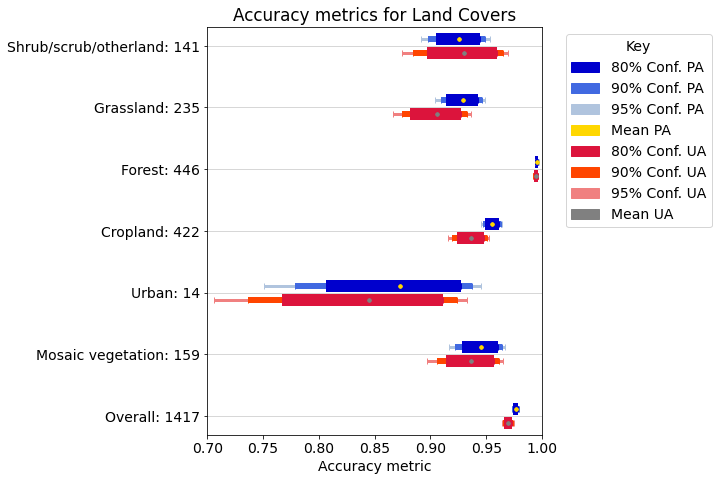

In [102]:
errorplot_precision_recall(lulc_conf, (6,7.5), 'Land Covers')
plt.savefig("lulc.pdf", dpi = 200, bbox_inches = "tight")
plt.savefig("lulc.png", dpi = 200, bbox_inches = "tight")

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


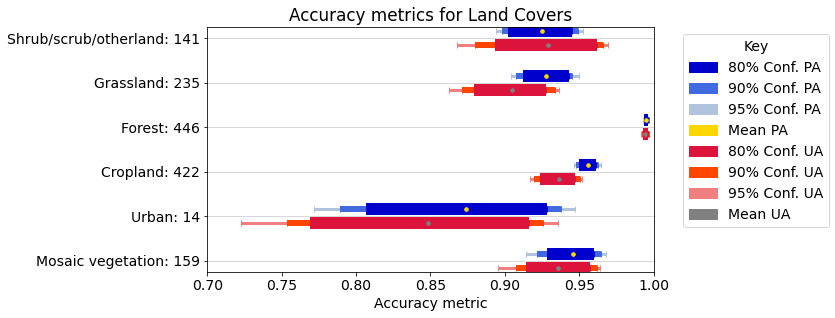

In [47]:
errorplot_precision_recall(lulc_conf, (8,4.5), 'Land Covers')
plt.savefig("lulc.pdf", dpi = 200, bbox_inches = "tight")
plt.savefig("lulc.png", dpi = 200, bbox_inches = "tight")

### Biomes

In [ ]:
errorplot_precision_recall(biome_conf, (10,6), 'Biomes')

### Tree Class

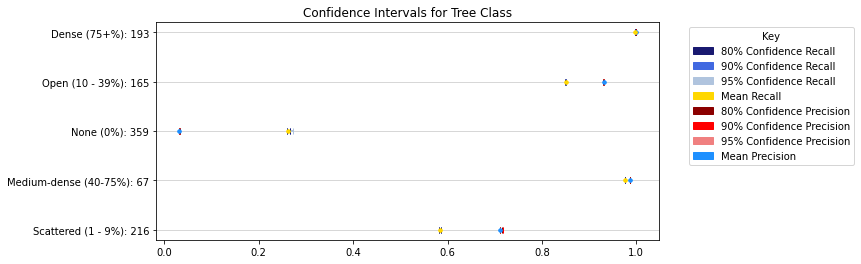

In [69]:
errorplot_precision_recall(treeclass_conf, (9,4), 'Tree Class')

### Ecoregion

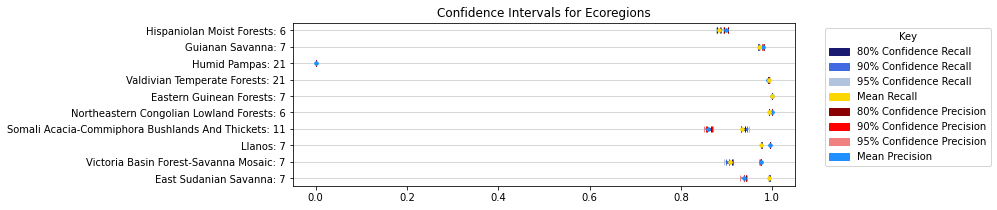

In [80]:
errorplot_precision_recall(ecoreg_conf[15:25], (9,3), 'Ecoregions')

### Country

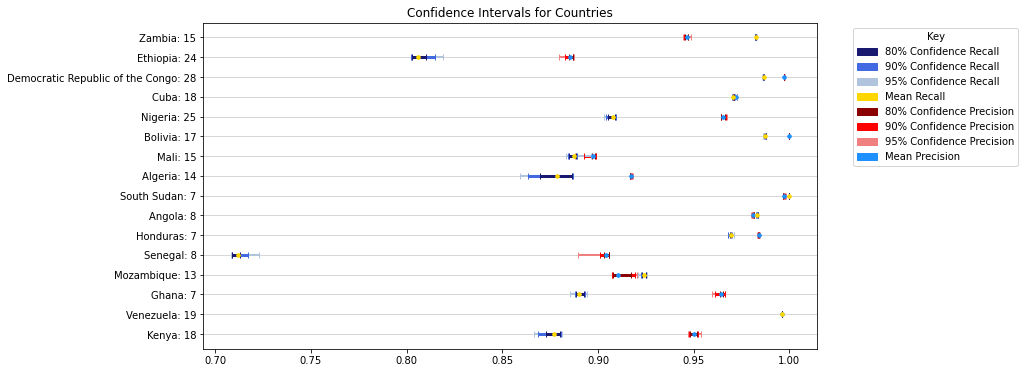

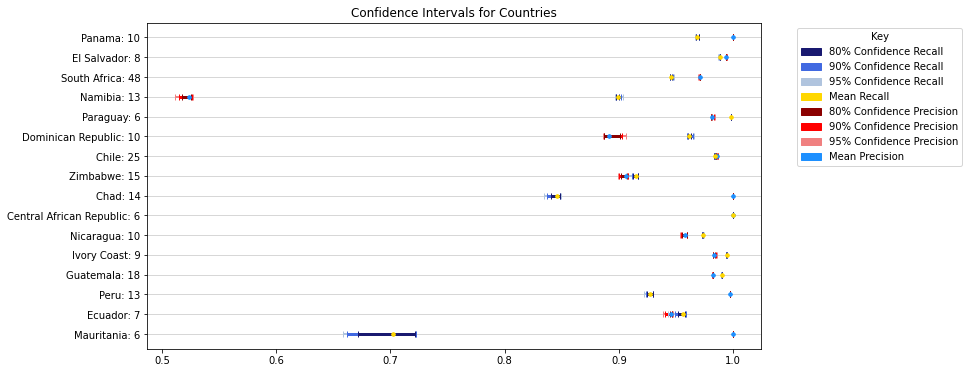

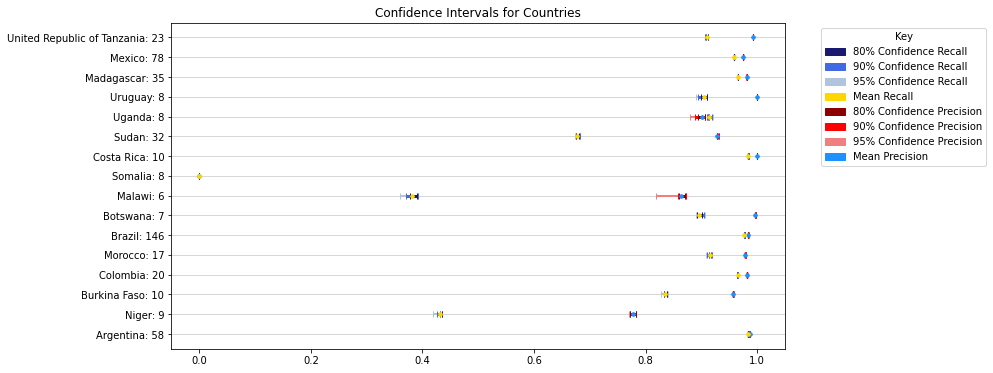

In [79]:
errorplot_precision_recall(country_conf[:16], (11,6), 'Countries')
errorplot_precision_recall(country_conf[16:32], (11,6), 'Countries')
errorplot_precision_recall(country_conf[32:], (11,6), 'Countries')

### Conclusions

We have $50k to spend on getting more validation analyses. Which countries or subregions do we prioritize?
Why the discrepencies between John's slides?
Should we try to prioritize biomes with mixed trees/shrubs?